In [1]:
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from ultralytics.data.dataset import YOLODataset
import time
import torch

In [2]:
train_dataset_path = "D:\\UGM\\tugas akhir\\datasets\\KITTI2017\\images\\train"
val_dataset_path = "D:\\UGM\\tugas akhir\\datasets\\KITTI2017\\images\\val"

# Load datasets
train_dataset = YOLODataset(
    img_path = train_dataset_path,
    augment = False,
    data = { 'nc': 7 }
)
val_dataset = YOLODataset(
    img_path = val_dataset_path,
    augment = False,
    data = { 'nc': 7 }
)

Fast image access  (ping: 0.30.2 ms, read: 76.48.0 MB/s, size: 803.5 KB)
Scanning D:\UGM\tugas akhir\datasets\KITTI2017\labels\train.cache... 5985 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5985/5985 6.0Mit/s 0.0s
Fast image access  (ping: 0.00.0 ms, read: 489.040.3 MB/s, size: 788.2 KB)
Scanning D:\UGM\tugas akhir\datasets\KITTI2017\labels\val.cache... 1496 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1496/1496 1.0Mit/s 0.0s


## Object Distance Distribution

In [3]:
USE_EUCLIDEAN = False

def extract_distances(dataset):
    distances = []

    for label in dataset.labels:
        for dist in label["distances"]:
            dx, dy, dz = dist
            
            if USE_EUCLIDEAN:
                d = torch.linalg.vector_norm(torch.tensor([dx, dy, dz]), ord=2).item()
            else:
                d = dz

            distances.append(float(d))

    return np.array(distances)

train_dist = extract_distances(train_dataset)
val_dist = extract_distances(val_dataset)

print(f"Train : {len(train_dist)} objects from {train_dataset.ni} images")
print(f"Val   : {len(val_dist)} objects from {val_dataset.ni} images")

Train : 31820 objects from 5985 images
Val   : 7777 objects from 1496 images


In [9]:
MAX_DIST = 160
BIN_STEP = 10

bins = np.arange(0, MAX_DIST + BIN_STEP, BIN_STEP)

train_counts, _ = np.histogram(train_dist, bins=bins)
val_counts, _ = np.histogram(val_dist,   bins=bins)

print("Distance interval  | Train |  Val")
print("-" * 34)

for i in range(len(bins) - 1):
    start = bins[i]
    end   = bins[i + 1]
    print(f"{start:3d}-{end:3d} m          | {train_counts[i]:5d} | {val_counts[i]:5d}")

Distance interval  | Train |  Val
----------------------------------
  0- 10 m          |  4719 |  1157
 10- 20 m          |  7748 |  1885
 20- 30 m          |  7001 |  1727
 30- 40 m          |  5138 |  1248
 40- 50 m          |  3362 |   807
 50- 60 m          |  2015 |   511
 60- 70 m          |  1032 |   271
 70- 80 m          |   678 |   139
 80- 90 m          |    88 |    20
 90-100 m          |    16 |     6
100-110 m          |     4 |     4
110-120 m          |     2 |     1
120-130 m          |     2 |     1
130-140 m          |     4 |     0
140-150 m          |     4 |     0
150-160 m          |     0 |     0


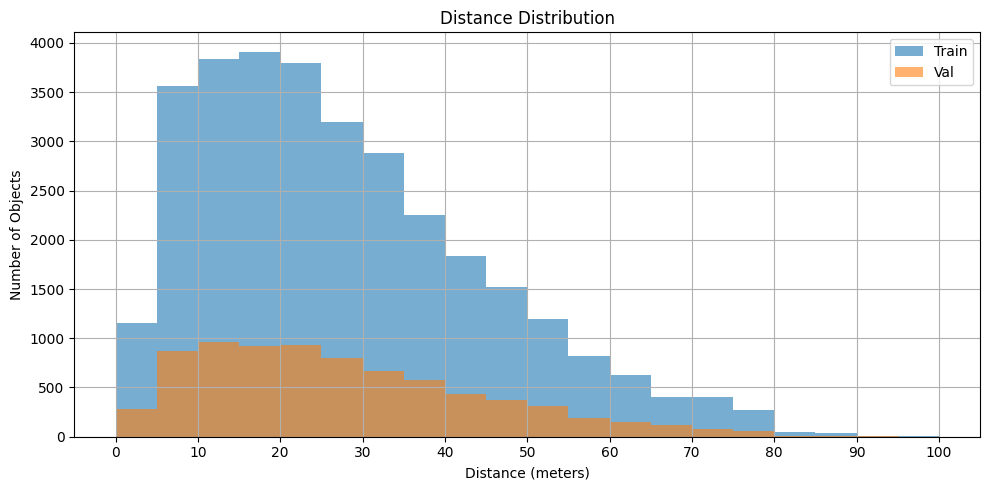

In [5]:
MAX_PLOT_DIST = 100  # clip for visibility (doesn't affect data)
BIN_STEP = 5

bins = np.arange(0, MAX_PLOT_DIST + BIN_STEP, BIN_STEP)

plt.figure(figsize=(10, 5))
plt.hist(train_dist, bins=bins, alpha=0.6, label="Train")
plt.hist(val_dist, bins=bins, alpha=0.6, label="Val")

plt.xlabel("Distance (meters)")
plt.ylabel("Number of Objects")
plt.title("Distance Distribution")
plt.xticks(np.arange(0, MAX_PLOT_DIST + 1, 10))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Box Dimension vs Distance Correlation

In [13]:
ONLY_SPECIFIC_CLASS = 1  # None to include all objects, or specify its class ID, e.g. 1 for only 'Car'

def extract_labels_data(labels):
    labels_min = [] # only store necessary values

    for label in labels:
        h, w = label["shape"]

        for cls, bbox, dist in zip(label["cls"], label["bboxes"], label["distances"]):
            if ONLY_SPECIFIC_CLASS is not None and cls.item() != ONLY_SPECIFIC_CLASS:
                continue
        
            x, y, bw, bh = bbox
            dx, dy, dz = dist
            d_euc = (dx**2 + dy**2 + dz**2)**0.5

            # normalize → pixel conversion
            x_px = x * w
            y_px = y * h
            bw_px = bw * w
            bh_px = bh * h

            labels_min.append([ bw_px, bh_px, dz, d_euc ]) # box width, box height, z dist, euclidean dist

    return np.array(labels_min) # N x 4 array

processed_labels = extract_labels_data(train_dataset.labels)
# processed_labels = extract_labels_data(val_dataset.labels)

combinations = [(0, 2), (0, 3), (1, 2), (1, 3)] # (bw,z), (bw,euc), (bh,z), (bh,euc)
keys = ['box_width', 'box_height', 'z_distance', 'euclidean_distance']

print('Calculating correlations...\n')

for combo in combinations:
    pearson, _ = pearsonr(processed_labels[:, combo[0]], processed_labels[:, combo[1]])
    spearman, _ = spearmanr(processed_labels[:, combo[0]], processed_labels[:, combo[1]])

    print(f"Correlation {keys[combo[0]]} vs {keys[combo[1]]}:")
    print("  Pearson:", pearson)
    print("  Spearman:", spearman)


Calculating correlations...

Correlation box_width vs z_distance:
  Pearson: -0.73567957
  Spearman: -0.8770454361932875
Correlation box_width vs euclidean_distance:
  Pearson: -0.7264474
  Spearman: -0.8583263180016303
Correlation box_height vs z_distance:
  Pearson: -0.80522734
  Spearman: -0.9904077806901095
Correlation box_height vs euclidean_distance:
  Pearson: -0.80155337
  Spearman: -0.9848452638917612


__Pearson__ finds __linear__ relationships for continuous, normally distributed data (sensitive to outliers)

__Spearman__ finds __monotonic__ (consistent directional) relationships for ordinal or non-normal data (robust to outliers)

The value is between -1 and 1:
* Positive values (e.g., +0.7): strong positive trend (both variables rank tend to go up)
* Negative values (e.g., -0.8): strong negative trend (one goes up, the other goes down)
* Values near zero (e.g., +0.1, -0.2): weak relationship (ranks don't consistently match up)

In [14]:
BOX_DIM_TYPE = 1  # 0 for box width, 1 for box height
DISTANCE_TYPE = 2  # 2 for z distance, 3 for euclidean distance

# Extract bbox height/width and distance
bd = processed_labels[:, BOX_DIM_TYPE]
bd = np.maximum(bd, 1e-6)  # avoid division by zero
inv_bd = 1.0 / bd  # get inverse

dis = processed_labels[:, DISTANCE_TYPE]

print('Fitting inverse regression model ' + 
     f'({"box height" if BOX_DIM_TYPE == 1 else "box width"} vs ' +
     f'{"z-axis distance" if DISTANCE_TYPE == 2 else "euclidean distance"}) ...\n')

# Fit inverse regression model: d = a * (1/h) + b
time_coeff_start = time.perf_counter()
coeffs = np.polyfit(inv_bd, dis, 1)
time_coeff_end = time.perf_counter()
print(f"Fitting time: {(time_coeff_end - time_coeff_start)*1000:.2f} ms")

a, b = coeffs
print(f"Inverse model: d ≈ {a:.6f} * (1/bh) + {b:.6f}")

# Predict d using the model
dis_pred = a * inv_bd + b

# Calculate MAE and MRE
mae = np.mean(np.abs(dis - dis_pred))
mre = np.mean(np.abs(dis - dis_pred) / np.maximum(dis, 1))

print(f"Prediction results:")
print(f"- MAE: {mae:.4f} meters")
print(f"- MRE: {mre*100:.2f} %")

Fitting inverse regression model (box height vs z-axis distance) ...

Fitting time: 1.61 ms
Inverse model: d ≈ 1099.856669 * (1/bh) + 1.827974
Prediction results:
- MAE: 1.8886 meters
- MRE: 13.40 %


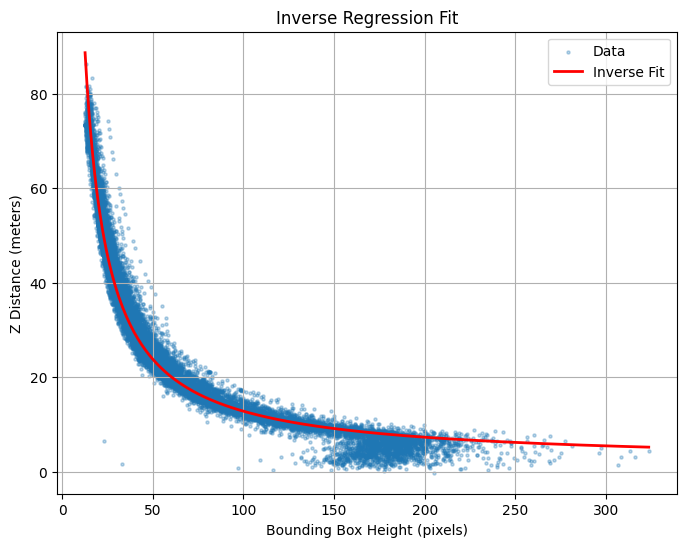

In [15]:
# Plot inverse regression curve
plt.figure(figsize=(8,6))
plt.scatter(bd, dis, s=5, alpha=0.3, label="Data")

# Draw smooth inverse curve
b_line = np.linspace(bd.min(), bd.max(), 300)
b_line_safe = np.maximum(b_line, 1e-6)
y_line = a * (1.0 / b_line_safe) + b

plt.plot(b_line, y_line, linewidth=2, color="red", label="Inverse Fit")
plt.xlabel(f"Bounding Box {'Height' if BOX_DIM_TYPE == 1 else 'Width'} (pixels)")
plt.ylabel(f"{'Z Distance' if DISTANCE_TYPE == 2 else 'Euclidean Distance'} (meters)")
plt.title("Inverse Regression Fit")
plt.legend()
plt.grid(True)
plt.show()